In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from reducer import*
from ensemble import*
from super_learner import*
from TLP import TLP
from scipy.stats import t

data_fn = '211205wave2e.csv'
title = 'wave2_'
df = pd.read_csv(data_fn)

cols = df.columns

print(cols)

def threshold_graph(digraph, threshold):
    cols = digraph.nodes
    # to dense
    cm = nx.adjacency_matrix(digraph).todense()

    plt.hist(cm.ravel().T, bins=20)
    plt.show()

    # threshold
    cm[cm < threshold] = 0.0
    cm[cm >= threshold] = 1.0
    
    # back to graph 
    df_cm = pd.DataFrame(cm, index =cols,
                  columns = cols)
    digraph = nx.from_pandas_adjacency(df_cm.T, create_using=nx.DiGraph())
    
    return digraph

def get_rents_children(graph, var):
    rents = list(graph.predecessors(var))
    children = list(graph.successors(var))
    return rents, children


    
def plot_subbgraph(G, variables, size=(10,8), subgraph_name='name', plot_adj=False):
    H = nx.subgraph(G, variables)
    variables = H.nodes
        
    cmap=plt.get_cmap('cool')
#     pos = nx.spring_layout(H)
    edge_widths = [w for (*edge, w) in H.edges.data('weight')]
    edge_colors = [w for (*edge, w) in H.edges.data('weight')]
    vmin = min(edge_colors)
    vmax = max(edge_colors)
    


    plt.figure(figsize=size)
    nx.draw_shell(H, width=edge_widths, with_labels=True, vmin=vmin, vmax=vmax,
            node_color='lightgreen', edge_color='k', 
            node_size=250, connectionstyle='arc3, rad=.15')   
    
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#     sm._A = []
#     cbar = plt.colorbar(sm)
#     cbar.set_label('Confidence', rotation=270)
    plt.savefig('results/' + subgraph_name + '.png', dpi=150)
    plt.show()
    
 
    
    if plot_adj:
        # to dense
        cmap = plt.get_cmap('viridis')
        cm = nx.adjacency_matrix(H).todense()
        df_cm = pd.DataFrame(cm, index=variables,
                  columns=variables)
    
        plt.figure(figsize = (23,18))
        sns.heatmap(df_cm, cmap=cmap)
        plt.xlabel('Effects')
        plt.ylabel('Causes')
        name = 'Adjacency Graph w/ Confidence Threshold: {}'.format(threshold)
        plt.title(name)
        plt.savefig('results/' + subgraph_name + '_adj.png', dpi=150)
        plt.show()  

        
vars_correct = ['W2_Risk_total', 'W2_Hygiene_total', 'W2_Dep_Total','W2_GAD_Total', 'W2_Loneliness_Total']
vars_divvo = [10.0, 11.0, 9, 7, 3]

for i, var in enumerate(vars_correct):
    df[var] = df[var] / vars_divvo[i]

Index(['W2_Age_year', 'W2_Gender', 'W2_Relationship', 'W2_Keyworker',
       'W2_Adults_household', 'W2_Children_household', 'W2_Change_Income',
       'W2_Chronic_illness_self', 'W2_Pregnant', 'W2_COVID19_anxiety',
       'W2_RISK_1month', 'W2_Risk_total', 'W2_Hygiene_total', 'W2_Dep_Total',
       'W2_GAD_Total', 'W2_Loneliness_Total', 'W2_Attach_Style'],
      dtype='object')


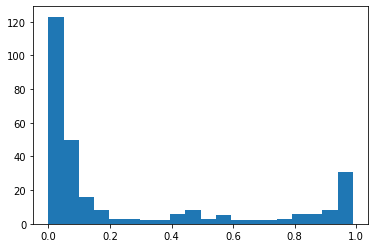

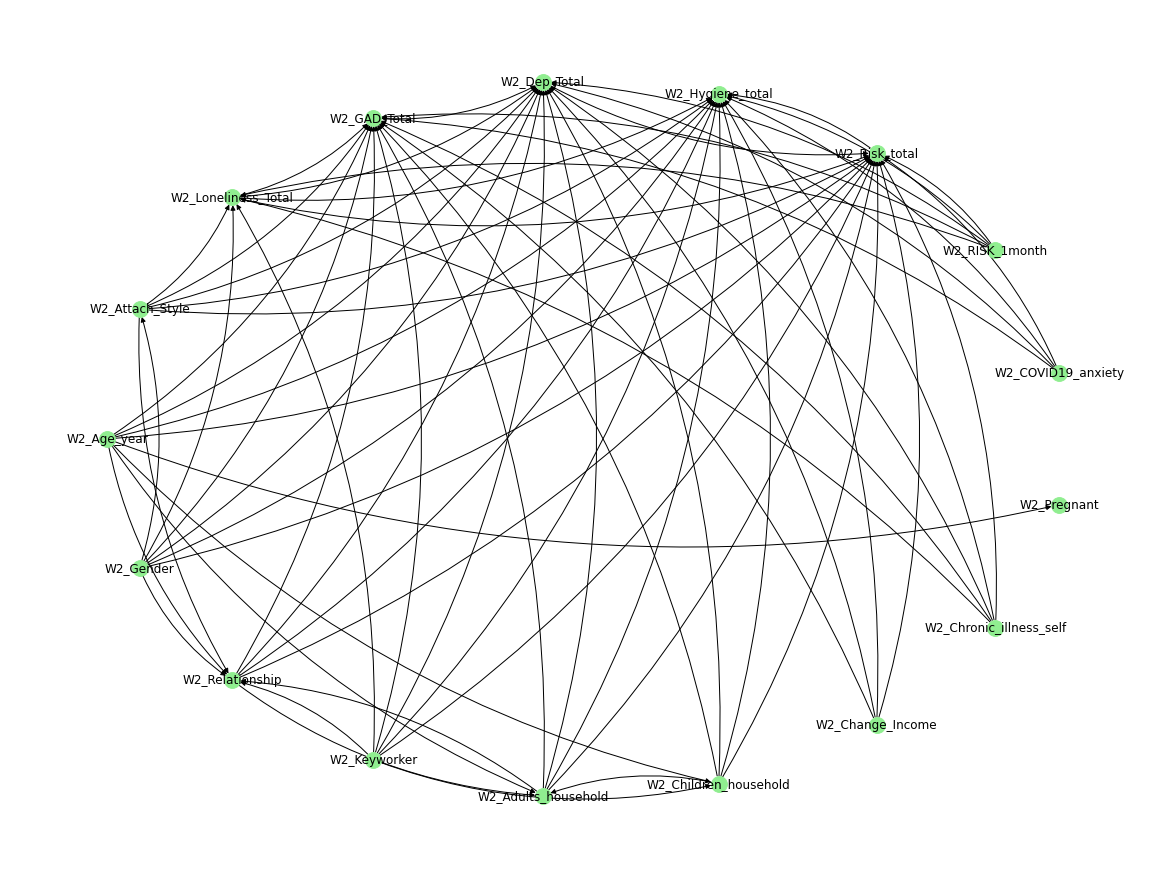

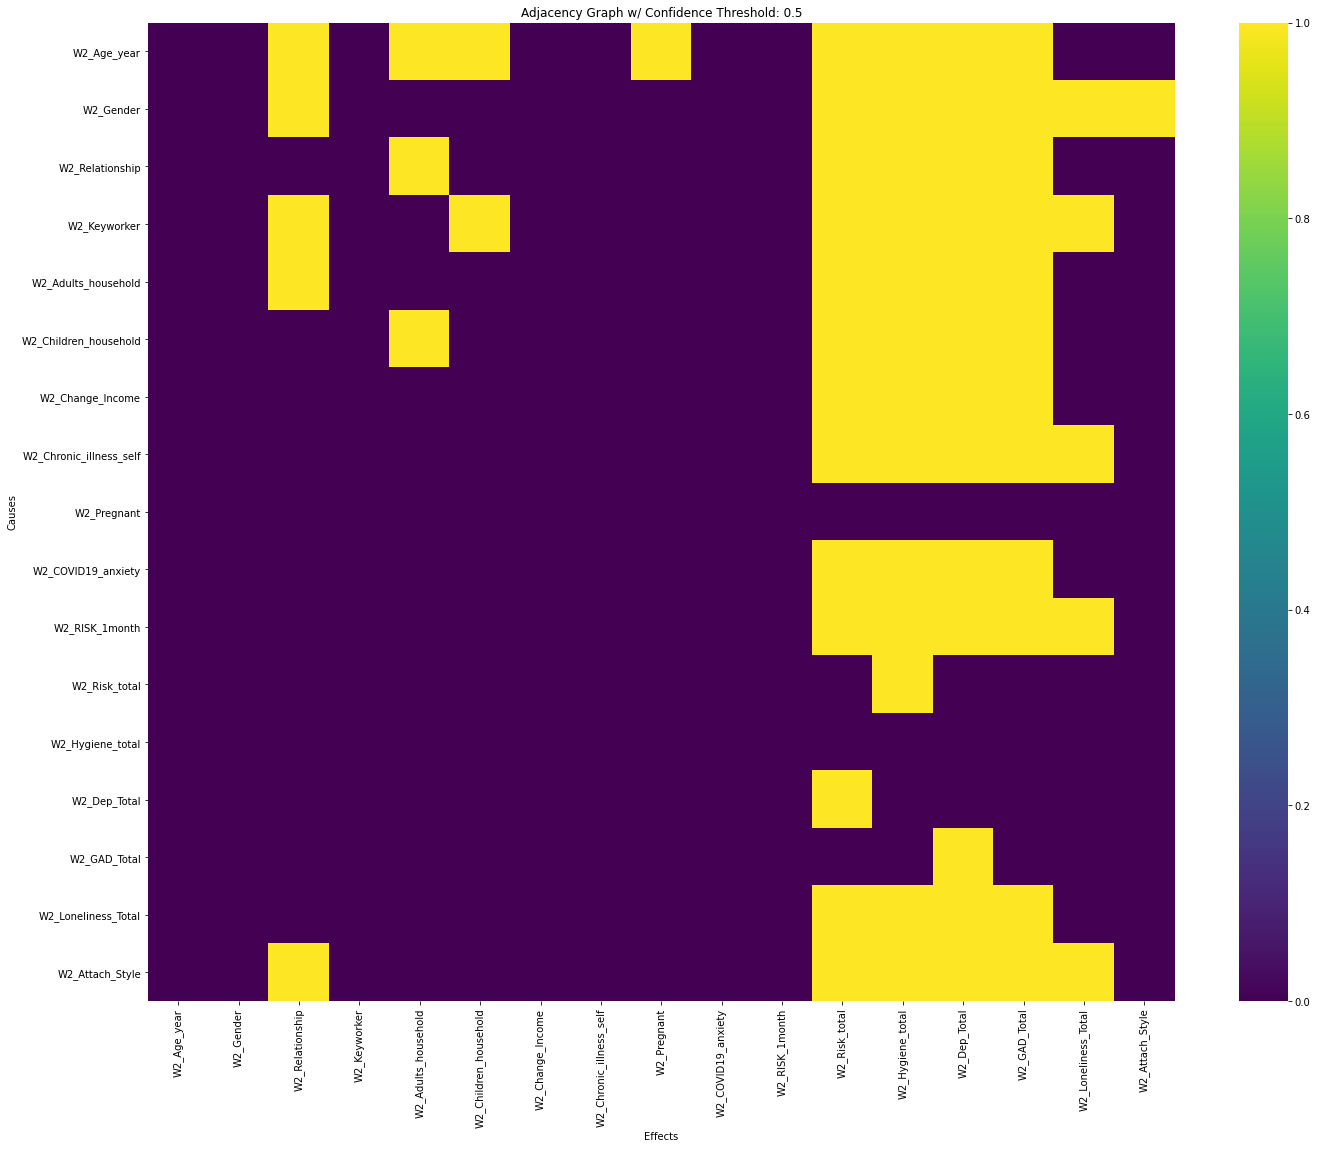

In [2]:
graph_name = 'wave_2_constrained_1var_attachment_lr_0.01_dagloss_True_dagpen_0.05_numruns_50.gml'
graph_name_short = '.'.join(graph_name.split('.')[:-1])

output = nx.read_gml("graphs/" + graph_name, destringizer=int)

threshold = 0.5
G_thresh = threshold_graph(output, threshold=threshold)
plot_subbgraph(G=G_thresh, variables=cols, subgraph_name=title+graph_name_short + '_all_{}'.format(threshold), size=(16,12), plot_adj=True)

In [3]:
# rents, children = get_rents_children(G_thresh, 'W2_GAD_Total')
# print('parents:',rents)
# print('children:', children)
# plot_subbgraph(G=G_thresh, subgraph_name=title+graph_name_short +'W2_GAD_Total_{}'.format(threshold), variables=rents+children+['W2_GAD_Total'], size=(16,12), plot_adj=True)

In [4]:

glen = 1
while glen > 0:
    cycle_list = list(nx.simple_cycles(G_thresh))
    print(cycle_list)
    glen = len(cycle_list)
    if glen == 0:
        break
    else:
        G_thresh.remove_edge(cycle_list[0][0], cycle_list[0][1])

[['W2_Adults_household', 'W2_Relationship']]
[]


In [ ]:
outcomes = ['W2_Risk_total','W2_Hygiene_total', 'W2_Dep_Total', 'W2_GAD_Total', 'W2_Loneliness_Total']
causes = ['W2_Attach_Style']


scale_ranges = [[1, 5], [1, 5], [0, 3], [0, 3], [1, 3]]

k=10

predictors_for_G = False

tl_ests = []
tl_ses = []
tl_ps = []

naives_effects = []
naives_ses = []
naives_ps = []

df['W2_Attach_Style'] -= 1

for i, ys in enumerate(outcomes):
    
    outcome_min, outcome_max = scale_ranges[i][0], scale_ranges[i][1]
    
    tl_lr_result = pd.DataFrame()
    tl_lr_result['outcome'] = [ys]
    
    tl_result = pd.DataFrame()
    tl_result['outcome'] = [ys]

    rd, confs, precs = reducer(G_thresh, causes, [ys],  remove_precision=True, project_causes=True, project_confs=True)
    print('outcome: ', ys, '. Confounders:', confs, '. Precisions:', precs, '\n')
    
    est_dict_Q = ['Elastic', 'BR', 'SV', 'LR', 'RF', 'MLP', 'AB', 'poly']
    est_dict_G = ['LR', 'NB', 'MLP','SV', 'poly', 'RF','AB']
    
    outcome_type = 'reg'   # cls or reg

    group_comparisons =[[1,0],[2,0],[3,0]]  # comparison in list format with 'group A [vs] reference_group'
    
    k = 8  # number of folds for SL training

    # initialise TLP object
    tlp = TLP(df, cause='W2_Attach_Style', outcome=ys, confs=list(confs),
              precs=list(precs), outcome_type=outcome_type, Q_learners=est_dict_Q, G_learners=est_dict_G,
             outcome_upper_bound= scale_ranges[i][1], outcome_lower_bound=scale_ranges[i][0])


    # fit SuperLearners
    all_preds_Q, gts_Q, all_preds_G, gts_G = tlp.fit(k=k, standardized_outcome=False, calibration=True)

    # 'do' targeted learning
    pre_update_effects, post_update_effects, ses, ps = tlp.target_multigroup(group_comparisons=group_comparisons)
    
    tl_ests.append(post_update_effects)
    tl_ses.append(ses)
    tl_ps.append(ps)
    
    naive_effects = {}
    naive_ses = {}
    naive_ps = {}
    for group_comparison in group_comparisons:
        group_a = group_comparison[0]
        group_ref = group_comparison[1]
        
        data_a = df[df.W2_Attach_Style == group_a][ys]
        data_ref = df[df.W2_Attach_Style == group_ref][ys]
        na = len(data_a)
        nref = len(data_ref)
        naive = data_a.mean() - data_ref.mean()
        data_a_se = np.std(data_a, ddof=1) / (np.sqrt(na))
        data_ref_se = np.std(data_ref, ddof=1) / (np.sqrt(nref))
        diff_se = np.sqrt(data_a_se**2 + data_ref_se**2)
        
        p = 2 * (1 - t.cdf(np.abs(naive) /diff_se, na+nref))
        
        naive_effects[str(group_comparison)] = naive
        naive_ses[str(group_comparison)] = diff_se
        naive_ps[str(group_comparison)] = p
        
    naives_effects.append(naive_effects)
    naives_ses.append(naive_ses)
    naives_ps.append(naive_ps)
        
        
        

    
   

 27%|██▋       | 3/11 [00:00<00:00, 25.94it/s]

outcome:  W2_Risk_total . Confounders: {'W2_Gender'} . Precisions: {'W2_Pregnant', 'W2_Age_year', 'W2_Children_household', 'W2_Change_Income', 'W2_Chronic_illness_self', 'W2_RISK_1month', 'W2_Keyworker', 'W2_COVID19_anxiety'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Generating G Predictions 
SuperLearner Training Completed.
Generating Predictions for Counterfactual Outcomes


 27%|██▋       | 3/11 [00:00<00:00, 23.76it/s]

Estimating Clever Covariates
Estimating Fluctuation Parameters
Updating Initial Counterfactual Predictions
Deriving the Influence Function
outcome:  W2_Hygiene_total . Confounders: {'W2_Gender'} . Precisions: {'W2_Pregnant', 'W2_Age_year', 'W2_Children_household', 'W2_Change_Income', 'W2_Chronic_illness_self', 'W2_RISK_1month', 'W2_Keyworker', 'W2_COVID19_anxiety'} 

Training Q Learners...


  0%|          | 0/7 [00:00<?, ?it/s]

Generating QAW Predictions 
Bounding outcome predictions.
Training G Learners...


 29%|██▊       | 2/7 [00:01<00:02,  1.71it/s]

In [ ]:
import statsmodels.api as sm
from scipy.special import logit, expit
group_clev_cov = tlp.clev_covs['[1, 0]'][0]


eps = sm.GLM(np.asarray(tlp.Q_Y).astype('float'), group_clev_cov, offset=logit(tlp.QAW),
                 family=sm.families.Binomial()).fit().params[0]

In [ ]:
print(np.isinf(logit(tlp.QAW)).sum())

In [ ]:
if predictors_for_G:
    tl_results.to_csv('targeted_learning_results_preds_for_G.csv', index=False)
    tl_lr_results.to_csv('targeted_learning_results_linear_preds_for_G.csv', index=False)  
else:
    tl_results.to_csv('targeted_learning_results.csv', index=False)
    tl_lr_results.to_csv('targeted_learning_results_linear.csv', index=False)

In [ ]:

plt.rcParams.update({'font.size': 13})


for outcome in outcomes:
    
    est_2_1 = tl_results[tl_results.outcome == outcome]['group_2_1_effect_star'].values
    ci_l_2_1 = tl_results[tl_results.outcome == outcome]['conf_int_L_2_1'].values
    ci_u_2_1 = tl_results[tl_results.outcome == outcome]['conf_int_U_2_1'].values
    
    est_3_1 = tl_results[tl_results.outcome == outcome]['group_3_1_effect_star'].values
    ci_l_3_1 = tl_results[tl_results.outcome == outcome]['conf_int_L_3_1'].values
    ci_u_3_1 = tl_results[tl_results.outcome == outcome]['conf_int_U_3_1'].values
    
    est_4_1 = tl_results[tl_results.outcome == outcome]['group_4_1_effect_star'].values
    ci_l_4_1 = tl_results[tl_results.outcome == outcome]['conf_int_L_4_1'].values
    ci_u_4_1 = tl_results[tl_results.outcome == outcome]['conf_int_U_4_1'].values
    
    est_2_1_naive = tl_results[tl_results.outcome == outcome]['group_2_1_effect_naive'].values
    ci_l_2_1_naive = tl_results[tl_results.outcome == outcome]['group_2_1_naive_ci_l'].values
    ci_u_2_1_naive = tl_results[tl_results.outcome == outcome]['group_2_1_naive_ci_u'].values
    
    est_3_1_naive = tl_results[tl_results.outcome == outcome]['group_3_1_effect_naive'].values
    ci_l_3_1_naive = tl_results[tl_results.outcome == outcome]['group_3_1_naive_ci_l'].values
    ci_u_3_1_naive = tl_results[tl_results.outcome == outcome]['group_3_1_naive_ci_u'].values
    
    est_4_1_naive = tl_results[tl_results.outcome == outcome]['group_4_1_effect_naive'].values
    ci_l_4_1_naive = tl_results[tl_results.outcome == outcome]['group_4_1_naive_ci_l'].values
    ci_u_4_1_naive = tl_results[tl_results.outcome == outcome]['group_4_1_naive_ci_u'].values
    
    print(outcome)
    print(est_2_1, ci_l_2_1, ci_u_2_1 )
    print(est_2_1_naive, ci_l_2_1_naive, ci_u_2_1_naive )
    
    
    plt.figure(figsize=(9,6))
    plt.title(outcome)
    plt.errorbar(x=['Fear vs Sec'], y=est_2_1, yerr=(ci_u_2_1-ci_l_2_1), capsize=10, fmt='o', color='b', label='Targeted')
    plt.errorbar(x=['Fear vs Sec naive'], y=est_2_1_naive, yerr=(ci_u_2_1_naive-ci_l_2_1_naive), capsize=5, fmt='x', color='r', label='Naive')
    
    plt.errorbar(x=['Anx vs Sec'], y=est_3_1, yerr=(ci_u_3_1-ci_l_3_1), capsize=10, fmt='o', color='b')
    plt.errorbar(x=['Anx vs Sec naive'], y=est_3_1_naive, yerr=(ci_u_3_1_naive-ci_l_3_1_naive), capsize=5, fmt='x', color='r')
    
    plt.errorbar(x=['Avo vs Sec'], y=est_4_1, yerr=(ci_u_4_1-ci_l_4_1), capsize=10, fmt='o', color='b')
    plt.errorbar(x=['Avo vs Sec naive'], y=est_4_1_naive, yerr=(ci_u_4_1_naive-ci_l_4_1_naive), capsize=5, fmt='x', color='r')
    
    plt.xlabel('Attachment Style')
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    if predictors_for_G:
        plt.savefig(outcome+'_targeted_comparison_preds_for_G.png', dpi=150)
    else:
        plt.savefig(outcome+'_targeted_comparison.png', dpi=150)
    
    plt.show()

In [ ]:

plt.rcParams.update({'font.size': 13})

for outcome in outcomes:
    
    est_2_1 = tl_lr_results[tl_lr_results.outcome == outcome]['group_2_1_effect_star'].values
    ci_l_2_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_L_2_1'].values
    ci_u_2_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_U_2_1'].values
    
    est_3_1 = tl_lr_results[tl_lr_results.outcome == outcome]['group_3_1_effect_star'].values
    ci_l_3_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_L_3_1'].values
    ci_u_3_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_U_3_1'].values
    
    est_4_1 = tl_lr_results[tl_lr_results.outcome == outcome]['group_4_1_effect_star'].values
    ci_l_4_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_L_4_1'].values
    ci_u_4_1 = tl_lr_results[tl_lr_results.outcome == outcome]['conf_int_U_4_1'].values
    
    est_2_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_2_1_effect_naive'].values
    ci_l_2_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_2_1_naive_ci_l'].values
    ci_u_2_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_2_1_naive_ci_u'].values
    
    est_3_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_3_1_effect_naive'].values
    ci_l_3_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_3_1_naive_ci_l'].values
    ci_u_3_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_3_1_naive_ci_u'].values
    
    est_4_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_4_1_effect_naive'].values
    ci_l_4_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_4_1_naive_ci_l'].values
    ci_u_4_1_naive = tl_lr_results[tl_lr_results.outcome == outcome]['group_4_1_naive_ci_u'].values

    plt.figure(figsize=(9,6))
    plt.title(outcome)
    plt.errorbar(x=['Fear vs Sec'], y=est_2_1, yerr=(ci_u_2_1-ci_l_2_1), capsize=5, fmt='o', color='b', label='Targeted (linear)')
    
    plt.errorbar(x=['Fear vs Sec naive'], y=est_2_1_naive, yerr=(ci_u_2_1_naive-ci_l_2_1_naive), capsize=5, fmt='x', color='r', label='Naive', ls='-.')
    
    plt.errorbar(x=['Anx vs Sec'], y=est_3_1, yerr=(ci_u_3_1-ci_l_3_1), capsize=5, fmt='o', color='b')
    
    plt.errorbar(x=['Anx vs Sec naive'], y=est_3_1_naive, yerr=(ci_u_3_1_naive-ci_l_3_1_naive), capsize=5, fmt='x', color='r', ls='-.')
    
    plt.errorbar(x=['Avo vs Sec'], y=est_4_1, yerr=(ci_u_4_1-ci_l_4_1), capsize=5, fmt='o', color='b')
    
    plt.errorbar(x=['Avo vs Sec naive'], y=est_4_1_naive, yerr=(ci_u_4_1_naive-ci_l_4_1_naive), capsize=5, fmt='x', color='r', ls='-.')
    

    plt.xlabel('Attachment Style')
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    if predictors_for_G:
        plt.savefig(outcome+'_targeted_comparison_linear_preds_for_G.png', dpi=150)
    else:
        plt.savefig(outcome+'_targeted_comparison_linear.png', dpi=150)
    plt.show()